In [2]:
import random
import datetime

import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from joblib import dump, load
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split



def read_data(path):
    '''读取数据'''
    try:
        data = pd.read_csv(path, engine='python', encoding='utf8')
        return data
    except FileNotFoundError:
        print('File not found. Please check the path and filename.')
        return None
    except Exception as e:
        print('An error occurred:', e)
        return None

def assess_metrics(truth,pred):
    '''MAE、MSE、RMSE、决定系数'''
    print('----')
    print('MAE: %.4f'%mean_absolute_error(truth,pred))
    print('MSE: %.4f'%mean_squared_error(truth,pred))
    print('RMSE: %.4f'%mean_squared_error(truth,pred,squared=False))
    print('R2: %.4f'%r2_score(truth,pred))
    return mean_squared_error(truth,pred,squared=False),r2_score(truth,pred)

def model_result(est,X_train_val, X_test, y_train_val, y_test):
    '''Train and test a model, and print the results'''
    # training
    y_train_pred = est.predict(X_train_val)
    print('train metrics')
    assess_metrics(y_train_val, y_train_pred)
    # test
    print('test metrics')
    y_test_pred = est.predict(X_test)
    RMSE, R2 = assess_metrics(y_test, y_test_pred)
    return RMSE, R2
def model_lineresult(est,model,year,X_train_val, X_test, y_train_val, y_test):
    '''Train and test a linear regression model, and print the results in a line'''
    date = datetime.datetime.now().strftime('%Y-%m-%d')
    # train and test
    y_train_pred = est.predict(X_train_val)
    y_test_pred = est.predict(X_test)
    print('{} {} {} 【Train_RMSE: {:.2f}, Train_R2: {:.2f}, Test_RMSE: {:.4f}, Test_R2: {:.2f}】'
          .format(date,year,model,mean_squared_error(y_train_val, y_train_pred,squared=False),r2_score(y_train_val, y_train_pred),
          mean_squared_error(y_test, y_test_pred,squared=False),r2_score(y_test, y_test_pred)))
    return mean_squared_error(y_test, y_test_pred,squared=False),r2_score(y_test, y_test_pred)

def soybean_real_time_feature(time,all_features):
    ''''''
    static_list = ['AREA_Irrigated','AREA','PIC','CaCO3','CEC','Drainage', 'EC','I_class','N_class', 'Max_OM', 'PAWS', 'pH', 'SAR', 
                   'Texture', 'Sand', 'Silt', 'Clay','sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield']
    # define the list of months you want to add to sub_list
    months_to_add = ['Mid Mar.','Late Mar.','Early Apr.','Mid Apr.','Late Apr.','Early May.','Mid May.','Late May.','Early Jun.',
                     'Mid Jun.','Late Jun.','Early Jul.','Mid Jul.','Late Jul.','Early Aug.','Mid Aug.','Late Aug.','Early Sep.',
                     'Mid Sep.','Late Sep.','Early Oct.','Mid Oct.','Late Oct.','Early Nov.','Mid Nov.','Late Nov.','Early Dec.',]
    sub_list = []
    if time in ['Mid Mar.','Late Mar.','Early Apr.','Mid Apr.','Late Apr.','Early May.']:
        # get the index of the month to stop adding elements
        stop_index = months_to_add.index(time)
        # add elements to sub_list until the stop_index is reached
        sub_list += months_to_add[:stop_index+1]
    elif time in ['Mid May.','Late May.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting']
        print(sub_list)
    elif time in ['Early Jun.','Mid Jun.','Late Jun.','Early Jul.','Mid Jul.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging']
    elif time in ['Late Jul.','Early Aug.','Mid Aug.','Late Aug.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Blooming']
    elif time in ['Early Sep.','Mid Sep.','Late Sep.','Early Oct.','Mid Oct.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Blooming','Podding']
    elif time in ['Late Oct.','Early Nov.','Mid Nov.','Late Nov.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Blooming','Podding','Dropping leaves']
    elif time in ['Early Dec.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Blooming','Podding','Dropping leaves','Harvest']
    else: None
    
    sub_list =  sub_list+static_list
    name_list = [element for element in all_features if any(substring in element for substring in sub_list)]
    return name_list

def maize_real_time_feature(time,all_features):
    ''''''
    static_list = ['AREA_Irrigated','AREA','PIC','CaCO3','CEC','Drainage', 'EC','I_class','N_class', 'Max_OM', 'PAWS', 'pH', 'SAR', 
                   'Texture', 'Sand', 'Silt', 'Clay','sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield']
    # define the list of months you want to add to sub_list
    months_to_add = ['Mid Mar.','Late Mar.','Early Apr.','Mid Apr.','Late Apr.','Early May.','Mid May.','Late May.','Early Jun.',
                     'Mid Jun.','Late Jun.','Early Jul.','Mid Jul.','Late Jul.','Early Aug.','Mid Aug.','Late Aug.','Early Sep.',
                     'Mid Sep.','Late Sep.','Early Oct.','Mid Oct.','Late Oct.','Early Nov.','Mid Nov.','Late Nov.','Early Dec.',]
    sub_list = []
    if time in ['Mid Mar.','Late Mar.','Early Apr.','Mid Apr.','Late Apr.','Early May.']:
        # get the index of the month to stop adding elements
        stop_index = months_to_add.index(time)
        # add elements to sub_list until the stop_index is reached
        sub_list += months_to_add[:stop_index+1]
    elif time in ['Mid May.','Late May.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting']
    elif time in ['Early Jun.','Mid Jun.','Late Jun.','Early Jul.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging']
    elif time in ['Mid Jul.','Late Jul.','Early Aug.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Silking']
    elif time in ['Mid Aug.','Late Aug.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Silking','Dough']
    elif time in ['Early Sep.','Mid Sep.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Silking','Dough','Dent']
    elif time in ['Late Sep.','Early Oct.','Mid Oct.','Late Oct.','Early Nov.','Mid Nov.','Late Nov.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Silking','Dough','Dent','Maturity']
    elif time in ['Early Dec.',]:
        stop_index = months_to_add.index(time)
        sub_list += months_to_add[:stop_index+1]
        sub_list = sub_list+['Planting','Emerging','Silking','Dough','Dent','Maturity','Harvest']     
    else: None
    
    sub_list =  sub_list+static_list
    name_list = [element for element in all_features if any(substring in element for substring in sub_list)]
    return name_list

In [6]:
def yield_predictor(data, test_year=[2020], N=2, experiment = 'GDT', croptype = 'soybean', model = ['XGBoost'], verbose = 0,
                    tune_model = False, model_parameter=None, result = False, result_dir = '', feature_importance = False,
                    fea_eng = False,seed = 99,save_model=False, save_model_dir='', trend_n = 30,
                    importance_dir = '', feature_list = None, n_features = 200, 
                    metric_list = [], nir_real_time = False, time ='', nir_result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                    no_feature_engineering = False):
    '''Yield predictor
    Parameters:
    
    '''
    # 近实时预测
    name_list = []
    all_features = data.columns.tolist()
    if nir_real_time ==True:
        if croptype=='soybean':
            name_list = soybean_real_time_feature(time,all_features)
        else:
            name_list = maize_real_time_feature(time,all_features)
#         name_list += ['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield']
        data = data[name_list]
    
    # 无特征工程
    if no_feature_engineering:
        # 子字符串
        substrings_to_remove = ["LSWI", "NDVI", "EVI", "GCVI", "RVI", "SAVI", "WDRVI", 'Planting', 'Emerging', 'Blooming', 'Podding', 'Dropping leaves', 'Harvest', 
                                'Planting', 'Emerging', 'Silking', 'Dough', 'Dent', 'Maturity', 'Harvest', 'PIC']
        # all_features保留下的特征列表
        name_list = [x for x in all_features if not any(sub in x for sub in substrings_to_remove)]
        data = data[name_list]

        
        
    if feature_importance == False:
    
        # select features using features importance
        if 'LR' in model:
            n_features = 20
        elif 'ANN'in model:
            n_features = 35
        elif 'RF'in model:
            n_features = 100
        elif 'KNN'in model:
            n_features = 20
        elif 'XGBoost'in model:
            n_features = 500
        else: None

        print('seed:',seed, 'croptype:',croptype,' ','test_year:',test_year[0],' ','model:',model[0],' ',
          'experiment:',experiment,' ','training year:',N,' ','trend_n：',trend_n,' ','n_feature：',n_features) 
        
        if nir_real_time ==True:
            # 近实时预测，如果特征数量不足五百，则不管，特征数量超过五百，取前存在的五百个
            common_features = list(set(feature_list['feature']) & set(data.columns))
            n_common_features = len(common_features)
            
            if n_common_features > n_features:
                feature_name = feature_list.loc[feature_list['feature'].isin(common_features), 'feature'].iloc[:n_features].tolist()
            else:
                feature_name = feature_list.loc[feature_list['feature'].isin(common_features), 'feature'].tolist()
                
        else:
            # 无特征工程预测，如果特征数量不足五百，则不管，特征数量超过五百，取前存在的五百个
            common_features = list(set(feature_list['feature']) & set(data.columns))
            n_common_features = len(common_features)
            
            if n_common_features > n_features:
                feature_name = feature_list.loc[feature_list['feature'].isin(common_features), 'feature'].iloc[:n_features].tolist()
            else:
                feature_name = feature_list.loc[feature_list['feature'].isin(common_features), 'feature'].tolist()

#             feature_name = feature_list.iloc[0:n_features]['feature'].tolist()
        feature_name = ['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield']+feature_name
        print(len(feature_name)-6)
        data = data[feature_name]
    else:
        None
    print(data.columns.shape[0])
    # split train-validation and test data
    # testset
    data_test = data[data['Year'].isin(test_year)]
    # tra-val set
    data_train_val = data[data['Year'].isin([i for i in range(test_year[0]-N,test_year[0])])]
    # split input and output
    y_train_val = data_train_val['yield(t/ha)']
    y_test = data_test['yield(t/ha)']
    
    if experiment == 'GDT': # GDT
        # de-trend the yield using linear model
        yield_mean = data_train_val['yield(t/ha)'].mean()
        linear_m = linear_model.LinearRegression()
        
        data_train_val1 = data[data['Year'].isin([i for i in range(test_year[0]-trend_n,test_year[0])])]
        X99 = np.array(data_train_val1['Year']).reshape(-1,1)
        Y99 = np.array(data_train_val1['yield(t/ha)']).reshape(-1,1)

        linear_m.fit(X99, Y99)
        if linear_m.coef_[0,0]<0:
            yield_mean = data_train_val['yield(t/ha)'].max()
        print('The foluma of de-trend the yield: yield_new = yield - {:.3f}×year + {:.3f} - ({:.3f})'
              .format(linear_m.coef_[0,0],yield_mean,linear_m.intercept_[0]))

        # de-trend data_train_val yield 
        data1 = data_train_val.copy()
        data1.loc[:,'yield(t/ha)_fix'] = data_train_val['yield(t/ha)'] - linear_m.coef_[0] * data_train_val['Year'] + yield_mean - linear_m.intercept_
        data1 = data1.drop(['yield(t/ha)'], axis = 1).rename({'yield(t/ha)_fix':'yield(t/ha)'}, axis=1)
        data_train_val = data1
        # de-trend data_test yield 
        data1 = data_test.copy()
        data1.loc[:,'yield(t/ha)_fix'] = data_test['yield(t/ha)'] - linear_m.coef_[0] * data_test['Year'] + yield_mean - linear_m.intercept_

        data1 = data1.drop(['yield(t/ha)'], axis = 1).rename({'yield(t/ha)_fix':'yield(t/ha)'}, axis=1)
        data_test = data1
        y_train_val = data_train_val['yield(t/ha)']
        y_test = data_test['yield(t/ha)']
        
        X_train_val = data_train_val.drop(['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield'], axis=1)# 
        X_test = data_test.drop(['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield'], axis=1) # 'Value'
    else: None
 
    # Scale numeric features
    columns_to_scale = X_train_val.columns.tolist()
    std_scaler = preprocessing.StandardScaler().fit(X_train_val[columns_to_scale])
    X_train_val.loc[:,columns_to_scale] = std_scaler.transform(X_train_val[columns_to_scale])
    X_test.loc[:,columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])
    
    # 模型选择 ['LR','RF','KNN','ANN','XGBoost','SVR']
    if 'LR' in model:
        est = linear_model.LinearRegression()
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'LR',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'RF'in model:
        est = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'RF',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'KNN'in model:
        est = neighbors.KNeighborsRegressor(10, weights='distance', n_jobs=-1)
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'KNN',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'ANN'in model:
        est = MLPRegressor(hidden_layer_sizes = 130, activation =  'tanh', solver = 'adam', early_stopping = True, max_iter = 10000)# mse/2
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'ANN',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'XGBoost'in model:
        est = XGBRegressor(max_depth= 7,learning_rate=0.09,n_estimators=700,seed=seed,objective= 'reg:gamma',
                           min_child_weight= 3,colsample_bytree=0.7, subsample= 0.8,reg_alpha= 0.1)# mse learning_rate=0.05,n_estimators=1000
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'XGBoost',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'SVR'in model:
        est = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.8)# C=30, gamma='auto', epsilon=0.5
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'SVR',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    else: 
        None
            
    # save the evaluated metrics
    if nir_real_time ==True:
        metric_list.append([time,seed, croptype, test_year[0], model[0], N,  RMSE,R2])
    else:
        metric_list.append([seed, croptype, test_year[0], model[0], N,  RMSE,R2])

   
    
    if save_model:
        dump(est, save_model_dir + croptype+'/'+ str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)) 
                                 
    if result:
        # get the yield and pred
        pred = est.predict(X_test)
        if croptype == 'maize':
            result = pd.concat([data.loc[y_test.index,['sta_con', 'yield(t/ha)']], pd.DataFrame(pred,index = y_test.index,columns=['pred'])],axis=1)
        else:
            result = pd.concat([data.loc[y_test.index,['sta_con', 'yield(t/ha)']], pd.DataFrame(pred,index = y_test.index,columns=['pred'])],axis=1)
        if experiment == 'GDT':
            result.loc[:,'pred'] = result.loc[:,'pred']+linear_m.coef_[0] * data_test['Year'] - yield_mean + linear_m.intercept_
        # result.loc[:,['yield','pred']] = result.loc[:,['yield','pred']]*62.719012*0.001
        result.loc[:,'residual'] =  result.loc[:,'pred'] - result.loc[:,'yield(t/ha)']
        if nir_real_time ==True:
            result.to_csv(nir_result_dir +croptype+'/'+time+str(seed) + '_' + str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_预测结果.csv',header=True)
        else:
            result.to_csv(result_dir +croptype+'/'+str(seed) + '_' + str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_预测结果.csv',header=True)
            # print('Results have been saved！')

    if feature_importance:
        importance_types = [ 'gain', 'cover', 'total_gain', 'total_cover']
        imp_dict = est.get_booster().get_score(importance_type = 'weight')
        imp_pd = pd.DataFrame.from_dict(imp_dict,orient ='index',columns = ['weight'])
        # print(imp_pd.index)
        for i in importance_types:
            imp_dict = est.get_booster().get_score(importance_type = i)
            imp_pd1 = pd.DataFrame.from_dict(imp_dict,orient ='index',columns = [i])
            imp_pd.loc[:,i] = imp_pd1.loc[:,i]
        imp_pd.to_csv(importance_dir +croptype+'/'+ str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_特征重要性.csv',header=True)
    
    shap_values = None
    if 'XGBoost'in model:
        explainer = shap.TreeExplainer(est)
        
        shap_values_train1 = explainer(X_train_val)
        shap_values_test1 = explainer(X_test)

        # Convert SHAP values to a pandas DataFrame
        df_shap_train1 = pd.DataFrame(shap_values_train1.values, columns=X_train_val.columns)
        df_shap_test1 = pd.DataFrame(shap_values_test1.values, columns=X_train_val.columns)

        # Save the SHAP values as a CSV file
        df_shap_train1.to_csv('D:/毕业大论文/结果/SHAP值结果/'+croptype+str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_shap_values_train.csv', index=False)
        df_shap_test1.to_csv('D:/毕业大论文/结果/SHAP值结果/'+croptype+str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_shap_values_test.csv', index=False)
        return shap_values_train1,shap_values_test1,metric_list#result #df_curve# imp_pd#
    return None,None,metric_list

### 2012和2016 留出一年 shap值图 因子耦合图 力图-大豆

In [40]:
data = read_data('D:/毕业大论文/数据/input_soybean_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/soybean/average_feature_importance.csv')

In [148]:
# one-year-out预测 2012年 大豆
crop_type = 'soybean'
metric_list = []
for year in range(2012,2013):
        shap_values_test,metric_list = yield_predictor1(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = False, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/one-year-out结果/',split='one-year-out')

seed: 99 croptype: soybean   test_year: 2012   model: XGBoost   experiment: GDT   training year: 10   trend_n： 30   n_feature： 500
{2016, 2017, 2018, 2019, 2020, 2021, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015}
The foluma of de-trend the yield: yield_new = yield - 0.040×year + 5.403 - (-76.924)
2023-03-23 [2012] XGBoost 【Train_RMSE: 0.02, Train_R2: 1.00, Test_RMSE: 0.3655, Test_R2: 0.66】


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


    EVI_Podding  EVI_Late Jul.  GCVI_Podding        NE  LSWI_Mid Aug.
8     -0.167441      -0.049685      0.366915 -0.310191      -0.335375
48    -0.915647      -0.819094     -0.656131 -0.310191      -1.657536
8     6.030447
48    5.472687
Name: yield(t/ha), dtype: float64


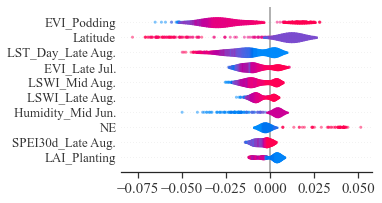

In [95]:
# shap图
sns.set_theme(style='ticks', font='Times New Roman', font_scale=8)
figure, ax = plt.subplots(1, 1, figsize=(20, 15))
figure = shap.summary_plot(shap_values_test, max_display=10, plot_type='violin', alpha=0.5, show=False, color_bar=False)
plt.xticks(fontsize=15)
ax.set_xlabel('')
# 修改y轴标签位置
ax.tick_params(axis='y', which='both', direction='inout',pad = -5)
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/'  + crop_type + model + '_' + str(year) + '_' + 'SHAP_test.png', dpi=500, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

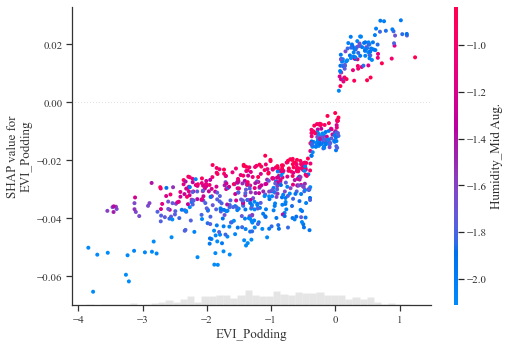

In [175]:
# 交互图
plt.clf()
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1)
shap.plots.scatter(shap_values_test[:,"EVI_Podding"], color=shap_values_test,show=False)# figure = ,'PDSI_Podding'EVI_Podding
# 调整图的边缘空白
plt.tight_layout()
# plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + model + '_' + str(year) + '_' + 'SHAP交互图.png', dpi=500, bbox_inches='tight')

In [176]:
# one-year-out预测 2016年 大豆
crop_type = 'soybean'
metric_list = []
for year in range(2016,2017):
        shap_values_test,metric_list = yield_predictor1(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = False, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/one-year-out结果/',split='one-year-out')

seed: 99 croptype: soybean   test_year: 2016   model: XGBoost   experiment: GDT   training year: 10   trend_n： 30   n_feature： 500
{2017, 2018, 2019, 2020, 2021, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
The foluma of de-trend the yield: yield_new = yield - 0.040×year + 5.403 - (-76.924)
2023-03-23 [2016] XGBoost 【Train_RMSE: 0.02, Train_R2: 1.00, Test_RMSE: 0.2583, Test_R2: 0.73】


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


    EVI_Podding  EVI_Late Jul.  GCVI_Podding        NE  LSWI_Mid Aug.
11     1.653515       2.027521      1.684894 -0.309255       0.739617
52     1.616153       2.027318      1.800920 -0.309255       0.862479
11    6.308136
52    6.610536
Name: yield(t/ha), dtype: float64


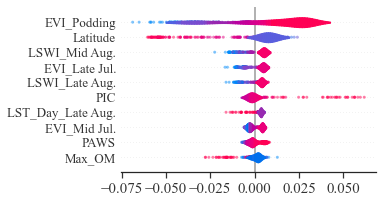

In [177]:
# shap图
sns.set_theme(style='ticks', font='Times New Roman', font_scale=8)
figure, ax = plt.subplots(1, 1, figsize=(20, 15))
figure = shap.summary_plot(shap_values_test, max_display=10, plot_type='violin', alpha=0.5, show=False, color_bar=False)
plt.xticks(fontsize=15)
ax.set_xlabel('')
# 修改y轴标签位置
ax.tick_params(axis='y', which='both', direction='inout',pad = -5)
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/'  + crop_type + model + '_' + str(year) + '_' + 'SHAP_test.png', dpi=500, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

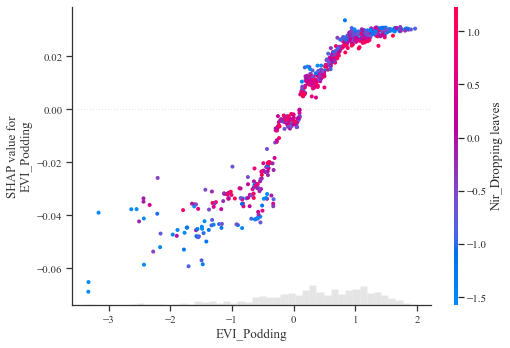

In [178]:
# 交互图
plt.clf()
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1)
shap.plots.scatter(shap_values_test[:,"EVI_Podding"], color=shap_values_test,show=False)# figure = ,'PDSI_Podding'EVI_Podding
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + model + '_' + str(year) + '_' + 'SHAP交互图.png', dpi=500, bbox_inches='tight')

### 2012和2016 留出一年 shap值图 因子耦合图 力图-玉米

In [179]:
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')

In [180]:
# one-year-out预测 2012年 玉米
crop_type = 'maize'
metric_list = []
for year in range(2012,2013):
        shap_values_test,metric_list = yield_predictor1(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = False, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/one-year-out结果/',split='one-year-out')

seed: 99 croptype: maize   test_year: 2012   model: XGBoost   experiment: GDT   training year: 10   trend_n： 30   n_feature： 500
{2016, 2017, 2018, 2019, 2020, 2021, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015}
The foluma of de-trend the yield: yield_new = yield - 0.155×year + 15.473 - (-301.348)
2023-03-23 [2012] XGBoost 【Train_RMSE: 0.06, Train_R2: 1.00, Test_RMSE: 1.2014, Test_R2: 0.77】


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


    EVI_Dough  EVI_Late Jul.  Nir_Dough  LSWI_Dough  Humidity_Mid Mar.
8   -0.226047      -0.288520  -0.325581    0.037161           4.672971
48  -0.648052      -0.779523  -0.570857   -0.431209           4.716444
8     14.185826
48    11.808776
Name: yield(t/ha), dtype: float64


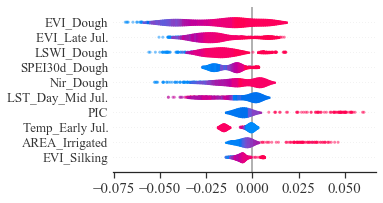

In [181]:
# shap图
sns.set_theme(style='ticks', font='Times New Roman', font_scale=8)
figure, ax = plt.subplots(1, 1, figsize=(20, 15))
figure = shap.summary_plot(shap_values_test, max_display=10, plot_type='violin', alpha=0.5, show=False, color_bar=False)
plt.xticks(fontsize=15)
ax.set_xlabel('')
# 修改y轴标签位置
ax.tick_params(axis='y', which='both', direction='inout',pad = -5)
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/'  + crop_type + model + '_' + str(year) + '_' + 'SHAP_test.png', dpi=500, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

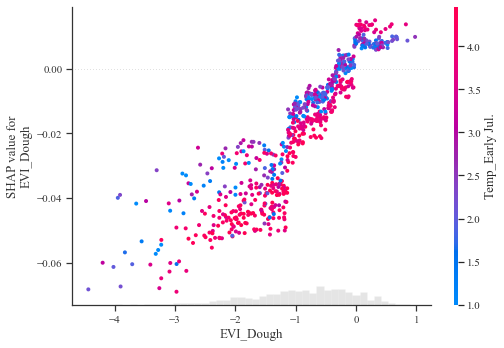

In [183]:
# 交互图
plt.clf()
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1)
shap.plots.scatter(shap_values_test[:,"EVI_Dough"], color=shap_values_test,show=False)# figure = ,'PDSI_Podding'EVI_Podding
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + model + '_' + str(year) + '_' + 'SHAP交互图.png', dpi=500, bbox_inches='tight')

In [184]:
# one-year-out预测 2016年 玉米
crop_type = 'maize'
metric_list = []
for year in range(2016,2017):
        shap_values_test,metric_list = yield_predictor1(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = False, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/one-year-out结果/',split='one-year-out')

seed: 99 croptype: maize   test_year: 2016   model: XGBoost   experiment: GDT   training year: 10   trend_n： 30   n_feature： 500
{2017, 2018, 2019, 2020, 2021, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}
The foluma of de-trend the yield: yield_new = yield - 0.155×year + 15.473 - (-301.348)
2023-03-23 [2016] XGBoost 【Train_RMSE: 0.06, Train_R2: 1.00, Test_RMSE: 0.8307, Test_R2: 0.75】


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


    EVI_Dough  EVI_Late Jul.  Nir_Dough  LSWI_Dough  Humidity_Mid Mar.
11   1.687649       1.889612   1.886239    1.095893           1.560026
52   1.532232       1.800080   1.729734    1.012554           1.532521
11    18.591201
52    18.898524
Name: yield(t/ha), dtype: float64


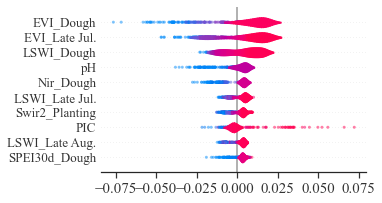

In [185]:
# shap图
sns.set_theme(style='ticks', font='Times New Roman', font_scale=8)
figure, ax = plt.subplots(1, 1, figsize=(20, 15))
figure = shap.summary_plot(shap_values_test, max_display=10, plot_type='violin', alpha=0.5, show=False, color_bar=False)
plt.xticks(fontsize=15)
ax.set_xlabel('')
# 修改y轴标签位置
ax.tick_params(axis='y', which='both', direction='inout',pad = -5)
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/'  + crop_type + model + '_' + str(year) + '_' + 'SHAP_test.png', dpi=500, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

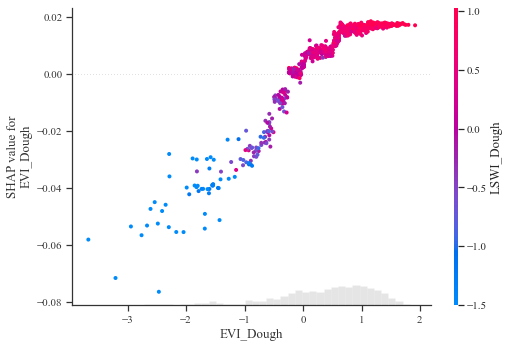

In [186]:
# 交互图
plt.clf()
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1)
shap.plots.scatter(shap_values_test[:,"EVI_Dough"], color=shap_values_test,show=False)# figure = ,'PDSI_Podding'EVI_Podding
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + model + '_' + str(year) + '_' + 'SHAP交互图.png', dpi=500, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

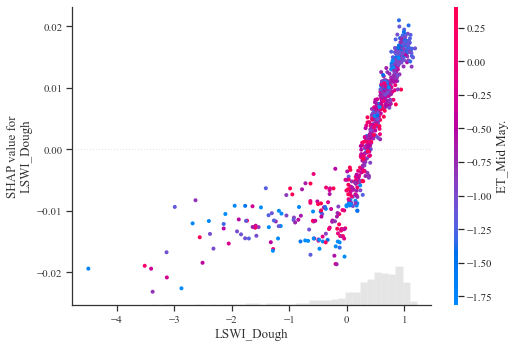

In [187]:
# 交互图
plt.clf()
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1)
shap.plots.scatter(shap_values_test[:,"LSWI_Dough"], color=shap_values_test,show=False)# figure = ,'PDSI_Podding'EVI_Podding
# 调整图的边缘空白
plt.tight_layout()
plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + model + '_' + str(year) + '_' + 'SHAP交互图LSWI.png', dpi=500, bbox_inches='tight')

### shap值图重新出-大豆

In [4]:
data = read_data('D:/毕业大论文/数据/input_soybean_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/soybean/average_feature_importance.csv')

In [ ]:
# 大豆预测
crop_type = 'soybean'
metric_list = []

for model in ['XGBoost']:#
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = [model],#shap_values,metric_list = 
                                                  verbose = 1, result = False, result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                                                  seed = 99, feature_list = featurelist,metric_list = metric_list) 
#         name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
        # treeexplainer plot save
        if model == 'XGBoost':
            sns.set_theme(style='ticks', font='Times New Roman', font_scale=8)
            figure, ax = plt.subplots(1, 1, figsize=(20, 15))
            figure = shap.summary_plot(shap_values_test, max_display=10, plot_type='violin', alpha=0.5, show=False, color_bar=False)

            plt.xticks(fontsize=15)
            ax.set_xlabel('')
            # 修改y轴标签位置
            ax.tick_params(axis='y', which='both', direction='inout',pad = -5)

            # 调整图的边缘空白
            plt.tight_layout()
            plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + '/' + model + '_' + str(year) + '_' + 'SHAP_test.png', dpi=500, bbox_inches='tight')
            plt.show()

### shap图重新出-玉米

In [37]:
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')

In [ ]:
# 玉米预测
crop_type = 'maize'
metric_list = []

for model in ['XGBoost']:#
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = [model],#shap_values,metric_list = 
                                                  verbose = 1, result = False, result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                                                  seed = 99, feature_list = featurelist,metric_list = metric_list) 
#         name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
        # treeexplainer plot save
        if model == 'XGBoost':
            sns.set_theme(style='ticks', font='Times New Roman', font_scale=8)
            figure, ax = plt.subplots(1, 1, figsize=(20, 15))
            figure = shap.summary_plot(shap_values_test, max_display=10, plot_type='violin', alpha=0.5, show=False, color_bar=False)

            plt.xticks(fontsize=15)
            ax.set_xlabel('')
            # 修改y轴标签位置
            ax.tick_params(axis='y', which='both', direction='inout',pad = -5)

            # 调整图的边缘空白
            plt.tight_layout()
            plt.savefig('D:/毕业大论文/可视化/python图/' + crop_type + '/' + model + '_' + str(year) + '_' + 'SHAP_test.png', dpi=500, bbox_inches='tight')
            plt.show()

In [29]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')
# print(data.columns.tolist())

In [ ]:
# 玉米预测
crop_type = 'maize'
metric_list = []

for model in ['XGBoost']:#
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = [model],#shap_values,metric_list = 
                                                  verbose = 1, result = False, result_dir = 'D:/毕业大论文/结果/不同模型结果/',n_features = 1300,
                                                  seed = 99, feature_list = featurelist,metric_list = metric_list) 

### 无特征工程结果

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_soybean_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/soybean/average_feature_importance.csv')

In [ ]:
# 无特征工程预测 大豆
crop_type = 'soybean'
metric_list = []
for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = True, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/无特征工程结果/',no_feature_engineering = True)
        
name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/无特征工程结果/' + crop_type +'_预测指标.csv',header=True)

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')

In [ ]:
# 无特征工程预测 玉米
crop_type = 'maize'
metric_list = []
for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = True, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/无特征工程结果/',no_feature_engineering = True)
        
name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/无特征工程结果/' + crop_type +'_预测指标.csv',header=True)

### 大豆2种划分策略结果

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_soybean_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/soybean/average_feature_importance.csv')

In [147]:
def yield_predictor1(data, test_year=[2020], N=2, experiment = 'GDT', croptype = 'soybean', model = ['XGBoost'], verbose = 0,
                    tune_model = False, model_parameter=None, result = False, result_dir = '', feature_importance = False,
                    fea_eng = False,seed = 99,save_model=False, save_model_dir='', trend_n = 30,
                    importance_dir = '', feature_list = None, n_features = 200, 
                    metric_list = [], nir_real_time = False, time ='', nir_result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                    split = None):
    '''Yield predictor
    Parameters:
    
    '''
    # 近实时预测
    name_list = []
    all_features = data.columns.tolist()
    if nir_real_time ==True:
        if croptype=='soybean':
            name_list = soybean_real_time_feature(time,all_features)
        else:
            name_list = maize_real_time_feature(time,all_features)
#         name_list += ['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield']
        data = data[name_list]
        
    if feature_importance == False:
    
        # select features using features importance
        if 'LR' in model:
            n_features = 20
        elif 'ANN'in model:
            n_features = 35
        elif 'RF'in model:
            n_features = 100
        elif 'KNN'in model:
            n_features = 20
        elif 'XGBoost'in model:
            n_features = 500
        else: None

        print('seed:',seed, 'croptype:',croptype,' ','test_year:',test_year[0],' ','model:',model[0],' ',
          'experiment:',experiment,' ','training year:',N,' ','trend_n：',trend_n,' ','n_feature：',n_features) 
        if nir_real_time ==True:
            # 近实时预测，如果特征数量不足五百，则不管，特征数量超过五百，取前存在的五百个
            common_features = list(set(feature_list['feature']) & set(data.columns))
            n_common_features = len(common_features)
            
            if n_common_features > n_features:
                feature_name = feature_list.loc[feature_list['feature'].isin(common_features), 'feature'].iloc[:n_features].tolist()
            else:
                feature_name = feature_list.loc[feature_list['feature'].isin(common_features), 'feature'].tolist()
        else:
            feature_name = feature_list.iloc[0:n_features]['feature'].tolist()
        feature_name = ['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield']+feature_name
        data = data[feature_name]
    else:
        None
    
    # 两种不同的划分策略
    # one-year-out
    # split train-validation and test data
    if split == 'one-year-out':
        # testset
        data_test = data[data['Year'].isin(test_year)]
        # tra-val set
        data_train_val = data[data['Year'].isin([year for year in range(2004, 2022) if year != test_year[0]])] 
        print(set(data_train_val['Year']))
    elif split == 'random':
        # testset
        data_train_val,data_test = train_test_split(data,test_size=0.2, random_state=seed)
    else:
        # testset
        data_test = data[data['Year'].isin(test_year)]
        # tra-val set
        data_train_val = data[data['Year'].isin([i for i in range(test_year[0]-N,test_year[0])])]
    # split input and output
    y_train_val = data_train_val['yield(t/ha)']
    y_test = data_test['yield(t/ha)']
    
    if experiment == 'GDT': # GDT
        # de-trend the yield using linear model
        yield_mean = data_train_val['yield(t/ha)'].max()
        linear_m = linear_model.LinearRegression()
        
        data_train_val1 = data[data['Year'].isin([i for i in range(2022-trend_n,2022)])]
        X99 = np.array(data_train_val1['Year']).reshape(-1,1)
        Y99 = np.array(data_train_val1['yield(t/ha)']).reshape(-1,1)

        linear_m.fit(X99, Y99)
        if linear_m.coef_[0,0]<0:
            yield_mean = data_train_val['yield(t/ha)'].max()
        print('The foluma of de-trend the yield: yield_new = yield - {:.3f}×year + {:.3f} - ({:.3f})'
              .format(linear_m.coef_[0,0],yield_mean,linear_m.intercept_[0]))

        # de-trend data_train_val yield 
        data1 = data_train_val.copy()
        data1.loc[:,'yield(t/ha)_fix'] = data_train_val['yield(t/ha)'] - linear_m.coef_[0] * data_train_val['Year'] + yield_mean - linear_m.intercept_
        data1 = data1.drop(['yield(t/ha)'], axis = 1).rename({'yield(t/ha)_fix':'yield(t/ha)'}, axis=1)
        data_train_val = data1
        # de-trend data_test yield 
        data1 = data_test.copy()
        data1.loc[:,'yield(t/ha)_fix'] = data_test['yield(t/ha)'] - linear_m.coef_[0] * data_test['Year'] + yield_mean - linear_m.intercept_

        data1 = data1.drop(['yield(t/ha)'], axis = 1).rename({'yield(t/ha)_fix':'yield(t/ha)'}, axis=1)
        data_test = data1
        y_train_val = data_train_val['yield(t/ha)']
        y_test = data_test['yield(t/ha)']
        
        X_train_val = data_train_val.drop(['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield'], axis=1)# 
        X_test = data_test.drop(['sta_con','State','yield(t/ha)','Year','Value','GDT_trend_yield'], axis=1) # 'Value'
    else: None
 
    # Scale numeric features
    columns_to_scale = X_train_val.columns.tolist()
    std_scaler = preprocessing.StandardScaler().fit(X_train_val[columns_to_scale])
    X_train_val.loc[:,columns_to_scale] = std_scaler.transform(X_train_val[columns_to_scale])
    X_test.loc[:,columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])
    
    # 模型选择 ['LR','RF','KNN','ANN','XGBoost','SVR']
    if 'LR' in model:
        est = linear_model.LinearRegression()
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'LR',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'RF'in model:
        est = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'RF',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'KNN'in model:
        est = neighbors.KNeighborsRegressor(10, weights='distance', n_jobs=-1)
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'KNN',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'ANN'in model:
        est = MLPRegressor(hidden_layer_sizes = 130, activation =  'tanh', solver = 'adam', early_stopping = True, max_iter = 10000)# mse/2
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'ANN',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'XGBoost'in model:
        est = XGBRegressor(max_depth= 7,learning_rate=0.09,n_estimators=700,seed=seed,objective= 'reg:gamma',
                           min_child_weight= 3,colsample_bytree=0.7, subsample= 0.8,reg_alpha= 0.1)# mse learning_rate=0.05,n_estimators=1000
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'XGBoost',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    elif 'SVR'in model:
        est = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.8)# C=30, gamma='auto', epsilon=0.5
        est.fit(X_train_val,y_train_val)
        if verbose == 0:
            RMSE,R2 = model_lineresult(est,'SVR',test_year,X_train_val, X_test, y_train_val, y_test)
        else:
            RMSE,R2 = model_result(est,X_train_val, X_test, y_train_val, y_test)
    else: 
        None
            
    # save the evaluated metrics
    if nir_real_time ==True:
        metric_list.append([time,seed, croptype, test_year[0], model[0], N,  RMSE,R2])
    else:
        metric_list.append([seed, croptype, test_year[0], model[0], N,  RMSE,R2])
                                 
    if result:
        # get the yield and pred
        pred = est.predict(X_test)
        if croptype == 'maize':
            result = pd.concat([data.loc[y_test.index,['sta_con', 'yield(t/ha)']], pd.DataFrame(pred,index = y_test.index,columns=['pred'])],axis=1)
        else:
            result = pd.concat([data.loc[y_test.index,['sta_con', 'yield(t/ha)']], pd.DataFrame(pred,index = y_test.index,columns=['pred'])],axis=1)
        if experiment == 'GDT':
            result.loc[:,'pred'] = result.loc[:,'pred']+linear_m.coef_[0] * data_test['Year'] - yield_mean + linear_m.intercept_
        # result.loc[:,['yield','pred']] = result.loc[:,['yield','pred']]*62.719012*0.001
        result.loc[:,'residual'] =  result.loc[:,'pred'] - result.loc[:,'yield(t/ha)']
        if nir_real_time ==True:
            result.to_csv(nir_result_dir +croptype+'/'+time+str(seed) + '_' + str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_预测结果.csv',header=True)
        else:
            result.to_csv(result_dir +croptype+'/'+str(seed) + '_' + str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_预测结果.csv',header=True)
            # print('Results have been saved！')
    shap_values = None
    if 'XGBoost'in model:
        explainer = shap.TreeExplainer(est)

        # shap_values_train1 = explainer(X_train_val)
        shap_values_test1 = explainer(X_test)
        print(X_test.iloc[0:2,0:5])
        print(y_test.iloc[0:2])# ['yield(t/ha)','EVI_Podding','Latitude']

        # Convert SHAP values to a pandas DataFrame
        # df_shap_train1 = pd.DataFrame(shap_values_train1.values, columns=X_train_val.columns)
        df_shap_test1 = pd.DataFrame(shap_values_test1.values, columns=X_train_val.columns)

        # Save the SHAP values as a CSV file
        # df_shap_train1.to_csv('D:/毕业大论文/结果/SHAP值结果/one-year-out SHAP/'+croptype+str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_shap_values_train.csv', index=False)
        df_shap_test1.to_csv('D:/毕业大论文/结果/SHAP值结果/one-year-out SHAP/'+croptype+str(test_year[0]) + '_' + model[0] + '_' + 'exp'+str(experiment)+'_N'+str(N)+'_shap_values_test.csv', index=False)
        return shap_values_test1,metric_list#result #df_curve# imp_pd#
    return None,None,metric_list

In [ ]:
# one-year-out预测
crop_type = 'soybean'
metric_list = []
for year in range(2004,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor1(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = True, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/one-year-out结果/',split='one-year-out')
        
name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/one-year-out结果/' + crop_type +'_预测指标.csv',header=True)

### 玉米2种划分策略结果

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')

In [ ]:
# one-year-out预测
crop_type = 'maize'
metric_list = []
for year in range(2004,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor1(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = True, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = False, result_dir = 'D:/毕业大论文/结果/one-year-out结果/',split='one-year-out')
        
name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/one-year-out结果/' + crop_type +'_预测指标.csv',header=True)

### 大豆近实时预测

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_soybean_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/soybean/average_feature_importance.csv')


In [ ]:
# 近实时预测
crop_type = 'soybean'
metric_list = []
# for time in ['Early Apr.','Mid Apr.',]:
for time in ['Mid Mar.','Late Mar.','Early Apr.','Mid Apr.','Late Apr.','Early May.','Mid May.','Late May.','Early Jun.',
            'Mid Jun.','Late Jun.','Early Jul.','Mid Jul.','Late Jul.','Early Aug.','Mid Aug.','Late Aug.','Early Sep.',
            'Mid Sep.','Late Sep.','Early Oct.','Mid Oct.','Late Oct.','Early Nov.','Mid Nov.','Late Nov.','Early Dec.',]:
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = True, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = True,time = time, nir_result_dir = 'D:/毕业大论文/结果/近实时预测结果/')
        
name = ['time','seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/近实时预测结果/' + crop_type +'_预测指标.csv',header=True)

### 玉米近实时预测

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')

In [ ]:
# 近实时预测
crop_type = 'maize'
metric_list = []
# for time in ['Early Apr.','Mid Apr.',]:
for time in ['Mid Mar.','Late Mar.','Early Apr.','Mid Apr.','Late Apr.','Early May.','Mid May.','Late May.','Early Jun.',
            'Mid Jun.','Late Jun.','Early Jul.','Mid Jul.','Late Jul.','Early Aug.','Mid Aug.','Late Aug.','Early Sep.',
            'Mid Sep.','Late Sep.','Early Oct.','Mid Oct.','Late Oct.','Early Nov.','Mid Nov.','Late Nov.','Early Dec.',]:
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data, test_year=[year], N=10, experiment = 'GDT', croptype = crop_type, model = ['XGBoost'], verbose = 0,
                    result = True, seed = 99, feature_list = featurelist, n_features = 500, metric_list = metric_list, 
                    nir_real_time = True,time = time, nir_result_dir = 'D:/毕业大论文/结果/近实时预测结果/')
        
name = ['time','seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/近实时预测结果/' + crop_type +'_预测指标.csv',header=True)

### 大豆预测

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_soybean_rename.csv')
# featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/soybean/average_feature_importance.csv')
# print(data.columns.tolist())

In [ ]:
# 保存特征重要性
crop_type = 'soybean'
for year in range(2014,2022):
    yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = ['XGBoost'],
                verbose = 0, result = False, seed = 99, feature_list = None, metric_list = [],
                feature_importance = True, importance_dir = 'D:/毕业大论文/结果/SHAP值结果/') 

In [ ]:
# 调优
# 大豆预测
crop_type = 'soybean'
metric_list = []
for i in [500]:# 2,5,10,15,20,25,30,35,40  20,50,100,200,300,500,700,900,1100,1300
    for model in ['XGBoost']:#,'LR','RF','KNN','ANN','XGBoost','SVR' 
        for year in range(2014,2022):
            shap_values_train,shap_values_test,metric_list = yield_predictor(data,croptype = crop_type, n_features = i,test_year = [year], N = 10, model = [model],#shap_values,metric_list = 
                                                      verbose = 0, result = False, result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                                                      seed = 99, feature_list = featurelist,metric_list = metric_list) 

In [ ]:
# 大豆预测
crop_type = 'soybean'
metric_list = []

for model in ['LR' ,'RF','KNN','ANN', 'XGBoost','SVR']:#
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = [model],#shap_values,metric_list = 
                                                  verbose = 1, result = True, result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                                                  seed = 99, feature_list = featurelist,metric_list = metric_list) 
        name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
        # treeexplainer plot save
        if model == 'XGBoost':
            sns.set_theme(style = 'ticks', font="Times New Roman", font_scale = 4)
            # 训练集
            # 小提琴图
            plt.clf()
            shap.summary_plot(shap_values_train,max_display=10,plot_type = 'violin',alpha = 0.5,show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'SHAP_train.png',dpi=500, bbox_inches='tight')
            # 清空画布
            plt.clf()
            # 重要性排行
            shap.summary_plot(shap_values_train,max_display=10,plot_type = 'bar',show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'特征重要性_train.png',dpi=500, bbox_inches='tight')
            # 测试集
            # 小提琴图
            plt.clf()
            shap.summary_plot(shap_values_test,max_display=10,plot_type = 'violin',alpha = 0.5,show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'SHAP_test.png',dpi=500, bbox_inches='tight')
            # 清空画布
            plt.clf()
            # 重要性排行
            shap.summary_plot(shap_values_test,max_display=10,plot_type = 'bar',show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'特征重要性_test.png',dpi=500, bbox_inches='tight')
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/' + crop_type +'_预测指标.csv',header=True)


### 玉米预测

In [ ]:
# 2014-2021，每10年预测一年
data = read_data('D:/毕业大论文/数据/input_maize_rename.csv')
featurelist = read_data('D:/毕业大论文/结果/SHAP值结果/maize/average_feature_importance.csv')
# print(data.columns.tolist())

In [ ]:
# 保存特征重要性
crop_type = 'maize'
for year in range(2014,2022):
    yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = ['XGBoost'],
                verbose = 0, result = False, seed = 99, feature_list = None, metric_list = [],
                feature_importance = True, importance_dir = 'D:/毕业大论文/结果/SHAP值结果/') 

In [ ]:
# 玉米预测
crop_type = 'maize'
metric_list = []

for model in ['LR' ,'RF','KNN','ANN', 'XGBoost','SVR']:#
    for year in range(2014,2022):
        shap_values_train,shap_values_test,metric_list = yield_predictor(data,croptype = crop_type, test_year = [year], N = 10, model = [model],#shap_values,metric_list = 
                                                  verbose = 1, result = True, result_dir = 'D:/毕业大论文/结果/不同模型结果/',
                                                  seed = 99, feature_list = featurelist,metric_list = metric_list) 
        name = ['seed', 'croptype', 'test_year', 'model', 'Train_years', 'RMSE', 'R2']
        # treeexplainer plot save
        if model == 'XGBoost':
            sns.set_theme(style = 'ticks', font="Times New Roman", font_scale = 4)
            # 训练集
            # 小提琴图
            shap.summary_plot(shap_values_train,max_display=10,plot_type = 'violin',alpha = 0.5,show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'SHAP_train.png',dpi=500, bbox_inches='tight')
            # 清空画布
            plt.clf()
            # 重要性排行
            shap.summary_plot(shap_values_train,max_display=10,plot_type = 'bar',show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'特征重要性_train.png',dpi=500, bbox_inches='tight')
            # 测试集
            # 小提琴图
            plt.clf()
            shap.summary_plot(shap_values_test,max_display=10,plot_type = 'violin',alpha = 0.5,show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'SHAP_test.png',dpi=500, bbox_inches='tight')
            # 清空画布
            plt.clf()
            # 重要性排行
            shap.summary_plot(shap_values_test,max_display=10,plot_type = 'bar',show=False)
            plt.savefig('D:/毕业大论文/可视化/python图/'+crop_type+'/'+model+'_'+str(year)+'_'+'特征重要性_test.png',dpi=500, bbox_inches='tight')
print(metric_list)
metric_df = pd.DataFrame(columns = name, data=metric_list)
metric_df.to_csv('D:/毕业大论文/结果/' + crop_type +'_预测指标.csv',header=True)